**Main Difference**
In this notebook, we assigned weights following a bell-shaped and left-skewed distribution. The highest weights were assigned to weeks_since_release values between 24 and 29, which are the target weeks for predicting iPhone 14 claims. We assigned smaller weights to weeks_since_release values farther from 24 and 29. 

This method resulted in a decrease of the WMAPE for iPhone 14 to 35.15% and 66.28% for each size and overall, respectively.

**Other settings** We are still using all of the iPhone data, including a column for the differencing claims.

In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

train = pd.read_excel("/data/p_dsi/teams2023/team1/apple/apple_train_data_final.xlsx")
test = pd.read_excel("/data/p_dsi/teams2023/team1/apple/apple_test_data_final.xlsx")

# merge the two dataframes
train['train'] = 1
test['train'] = 0
orig_data = pd.concat([train, test], axis=0).drop(['phone model', 'day'], axis=1)
orig_data.set_index('weeks_monday', inplace=True)  
orig_data.index = pd.to_datetime(orig_data.index, format='%Y-%m-%d')
orig_data.loc[orig_data.index.isin(['2022-12-19', '2022-12-26']), 'train'] = 1

orig_data.sample(10)

,phone size,phone color,claim,generation,week_of_month,month,year,weeks_since_release,is_holiday,train
weeks_monday,,,,,,,,,,
2021-09-06,128,gold,2,6s,1,9,2021,311.857143,1,1
2023-01-02,256,coral,2,xr,1,1,2023,218.428571,0,0
2022-01-03,256,black,19,xr,1,1,2022,166.428571,0,1
2023-02-13,128,green,8,11,2,2,2023,177.428571,0,0
2023-02-13,128,purple,15,11,2,2,2023,177.428571,0,0
2021-07-12,64,silver,1,6,2,7,2021,355.428571,1,1
2023-01-16,128,pink,125,13,3,1,2023,68.428571,0,0
2021-06-28,64,gold,5,6s,4,6,2021,301.857143,1,1
2021-12-06,16,gray,4,6s,1,12,2021,324.857143,0,1


### functions

In [2]:
def wmape(actual, forecast):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE) with equal weights"""
 
    numerator = np.sum(np.abs(actual - forecast)) * 100
    denominator = np.sum(np.abs(actual))

    return numerator/denominator

## set the weights for different models
def get_weight(week_since_release, mean = 26.5, std_dev = 8.5): 
    if week_since_release > 24 and week_since_release < 29:
        return 1
    weight = math.exp(-0.5*((week_since_release - mean)/std_dev)**2)
    return max(0, weight)
    
# plot the claim for each phone size 
def plot_ip14_claim_pred(plot_df, title = 'training data : add 2 weeks data', grouping = False, target = 'claim'):
    fig, ax = plt.subplots(figsize=(10, 6))

    if grouping == False:
        color_dict = {128: 'red', 256: 'blue', 512: 'green'}
        for size in plot_df['phone size'].unique():
            color = color_dict[size]
            ax.plot(plot_df.loc[plot_df['phone size'] == size, target], color=color, label=size)
            ax.plot(plot_df.loc[plot_df['phone size'] == size, 'pred'], color=color, linestyle='--', label=size)
    else:
        ax.plot(plot_df[target], label='actual', linewidth = 2)
        ax.plot(plot_df['pred'], linestyle='--', label='pred', linewidth = 2)
        # add markers to the last 4 weeks
        for i in range(4):
            ax.plot(plot_df.index[-1-i], plot_df['pred'][-1-i], marker='o', color='orange', markersize=6)

    ax.set_title('IPhone 14 Claim Prediction for each phone size')
    ax.set_xlabel('Weeks monday')
    ax.set_ylabel('Claim')
    ax.legend()
    ax.set_title(title)
    # add grid
    ax.grid(True)
    plt.show()

## print the rmse and test wmape. if show_train set to Ture, the train wmape will be print.
def print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=False):
    print("test WMAPE: {:.2f}%".format(wmape(y_test, y_pred)))
    if show_train:
        print("train WMAPE: {:.2f}%".format(wmape(y_train, y_train_fit)))
    #calculate the rmse
    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('rmse:', round(rmse, 3))

## the GB model for predicting over all iphone 14 claims

loss='absolute_error', subsample=0.4, max_depth = 7, n_estimators = 105, learning_rate=0.035, random_state=42

custom_weights : std_dev = 5

In [3]:
# group by weeks_monday and generation, but keep all other columns, including week_of_month, month, year, weeks_since_release, is_holiday, day, train
all_agg_dat = orig_data.groupby(['weeks_monday', 'generation']).agg({'week_of_month': 'first', 'year': 'first', 'month': 'first', 'weeks_since_release': 'first', 'is_holiday': 'first', 'train': 'first', 'claim': 'sum'}).reset_index().set_index('weeks_monday')

exp_dat = all_agg_dat.copy()
exp_dat = pd.get_dummies(exp_dat, columns=['generation'])

train = exp_dat[exp_dat['train'] == 1].drop(['train'], axis=1)
test = exp_dat[exp_dat['train'] == 0].drop(['train'], axis=1)

x_train = train.drop(['claim'], axis=1)
y_train = train['claim']

x_test = test.drop(['claim'], axis=1)
y_test = test['claim']

train.shape, test.shape

((1015, 23), (121, 23))

test WMAPE: 54.01%
train WMAPE: 98.38%
rmse: 847.883
iphone 14 WMAPE: 45.53%


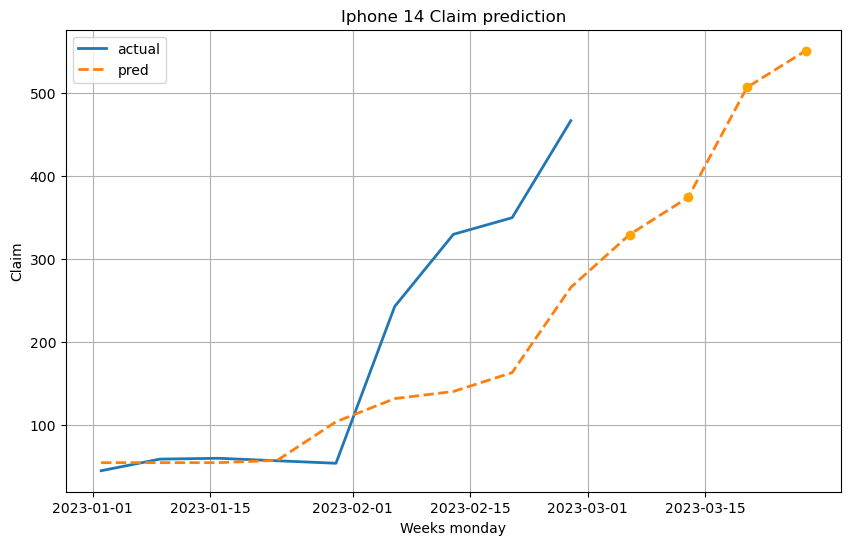

In [5]:
## the model minimizes the wmape for iphone 14
model = GradientBoostingRegressor(loss='absolute_error', subsample=0.35, max_depth = 3, n_estimators = 95, 
                                  learning_rate=0.061, random_state=42)
model2 = GradientBoostingRegressor(loss='absolute_error', subsample=0.75, max_depth = 7, n_estimators = 105, 
                                  learning_rate=0.036,random_state=42)
model3 = GradientBoostingRegressor(loss='huber', subsample=0.8, max_depth = 4, n_estimators = 105,
                                   learning_rate=0.036,random_state=42)

# set weights
train['weights'] = train['weeks_since_release'].apply(lambda x: get_weight(x, std_dev=29))

# Fit the model to the training data with custom sample weights
model3.fit(x_train, y_train, train['weights'])
y_pred = model3.predict(x_test)
y_train_fit = model3.predict(x_train)

print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=True)

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model3.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)

# prediction for the next 4 weeks
pred_df = test.loc[test['generation_14'] == 1].tail(4).drop(['claim'], axis=1)
pred_df['month'] = 3
pred_df['weeks_since_release'] = pred_df['weeks_since_release']+4
pred_df.index = pd.date_range(start='2023-03-06', periods=4, freq='W-MON')

pred_df['pred'] = model3.predict(pred_df)
# fill the claim with NA
pred_df['claim'] = np.nan
# switch position of claim and pred and keep the other columns
pred_df = pred_df[['week_of_month', 'year', 'month', 'weeks_since_release', 'is_holiday', 'generation_11', 'generation_12', 'generation_13', 'generation_14',
       'generation_3gs', 'generation_4', 'generation_4s', 'generation_5', 'generation_5s', 'generation_6', 'generation_6s', 'generation_7', 'generation_8', 'generation_se', 'generation_x', 'generation_xr',
       'generation_xs', 'claim', 'pred']]
plot_df = pd.concat([plot_df, pred_df], axis=0)

plot_ip14_claim_pred(plot_df, title = 'Iphone 14 Claim prediction', grouping=True)

In [6]:
pred_df['pred']

2023-03-06    329.634277
2023-03-13    374.578820
2023-03-20    507.091200
2023-03-27    551.328422
Freq: W-MON, Name: pred, dtype: float64

### retrian the model on the whole data 

In [10]:
new_df

,week_of_month,year,month,weeks_since_release,is_holiday,claim,generation_11,generation_12,generation_13,generation_14,...,generation_5,generation_5s,generation_6,generation_6s,generation_7,generation_8,generation_se,generation_x,generation_xr,generation_xs
weeks_monday,,,,,,,,,,,,,,,,,,,,,
2021-06-28,4,2021,6,92.428571,1,1499,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-06-28,4,2021,6,32.428571,1,422,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-06-28,4,2021,6,506.428571,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-06-28,4,2021,6,457.428571,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2021-06-28,4,2021,6,406.857143,1,3,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,4,2023,2,283.428571,0,256,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2023-02-27,4,2023,2,360.571429,0,223,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2023-02-27,4,2023,2,277.428571,0,174,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
final_pred_df = pred_df.drop(['claim', 'pred'], axis=1)

In [18]:
new_df = exp_dat.drop(['train'], axis=1)
new_x_train = new_df.drop(['claim'], axis=1)
new_y_train = new_df['claim']

# train the new model
model3 = GradientBoostingRegressor(loss='huber', subsample=0.8, max_depth = 4, n_estimators = 105,
                                   learning_rate=0.036,random_state=42)

new_df['weights'] = new_df['weeks_since_release'].apply(lambda x: get_weight(x, std_dev=29))

# Fit the model to the training data with custom sample weights
model3.fit(new_x_train, new_y_train, new_df['weights'])


final_pred_df['pred'] = model3.predict(final_pred_df)

iphone 14 WMAPE: 18.20%


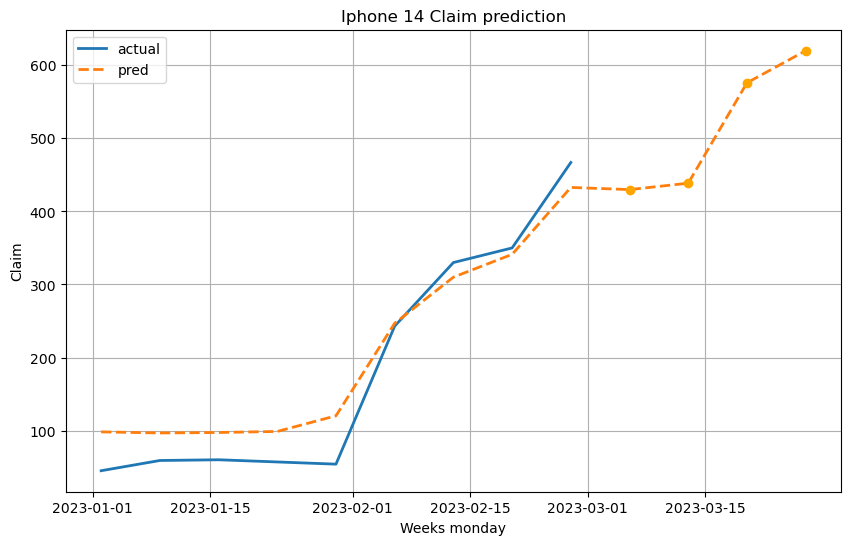

In [20]:

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model3.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)

# prediction for the next 4 weeks
final_pred_df = test.loc[test['generation_14'] == 1].tail(4).drop(['claim'], axis=1)
final_pred_df['month'] = 3
final_pred_df['weeks_since_release'] = final_pred_df['weeks_since_release']+4
final_pred_df.index = pd.date_range(start='2023-03-06', periods=4, freq='W-MON')

final_pred_df['pred'] = model3.predict(final_pred_df)
# fill the claim with NA
final_pred_df['claim'] = np.nan
# switch position of claim and pred and keep the other columns
final_pred_df = final_pred_df[['week_of_month', 'year', 'month', 'weeks_since_release', 'is_holiday', 'generation_11', 'generation_12', 'generation_13', 'generation_14',
       'generation_3gs', 'generation_4', 'generation_4s', 'generation_5', 'generation_5s', 'generation_6', 'generation_6s', 'generation_7', 'generation_8', 'generation_se', 'generation_x', 'generation_xr',
       'generation_xs', 'claim', 'pred']]
plot_df = pd.concat([plot_df, final_pred_df], axis=0)

plot_ip14_claim_pred(plot_df, title = 'Iphone 14 Claim prediction', grouping=True)

In [19]:
final_pred_df['pred']

2023-03-06    429.863535
2023-03-13    438.639258
2023-03-20    576.068554
2023-03-27    620.000861
Freq: W-MON, Name: pred, dtype: float64

### no weights

test WMAPE: 35.15%
train WMAPE: 19.03%
rmse: 674.845
iphone 14 WMAPE: 56.67%


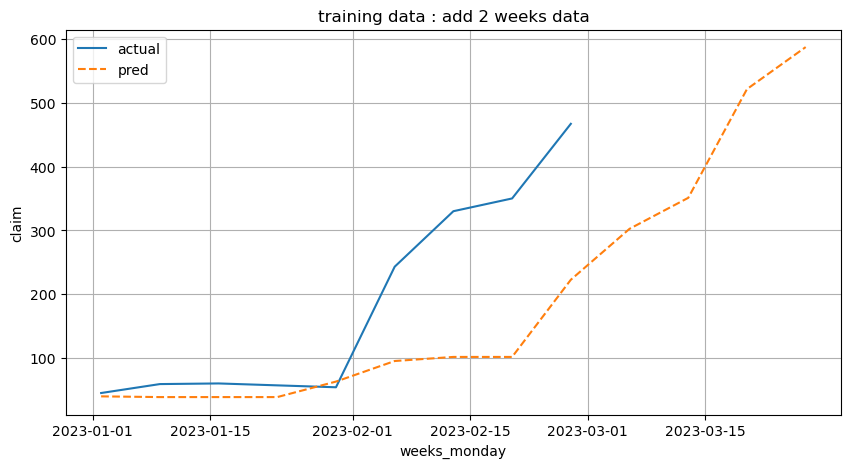

In [295]:
## the model minimizes the wmape for iphone 14
model = GradientBoostingRegressor(loss='absolute_error', subsample=0.8, max_depth = 3, n_estimators = 105, 
                                  learning_rate=0.041, random_state=42)
model2 = GradientBoostingRegressor(loss='huber', subsample=0.79, max_depth = 3, n_estimators = 105, 
                                  learning_rate=0.041,random_state=42)
model3 = GradientBoostingRegressor(loss='huber', subsample=0.35, max_depth = 9, n_estimators = 245, 
                                  learning_rate=0.096,random_state=42)


# set weights
train['weights'] = train['weeks_since_release'].apply(lambda x: get_weight(x, std_dev=44))

# Fit the model to the training data with custom sample weights
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_fit = model.predict(x_train)

print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=True)

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)

# prediction for the next 4 weeks
pred_df = test.loc[test['generation_14'] == 1].tail(4).drop(['claim'], axis=1)
pred_df['month'] = 3
pred_df['weeks_since_release'] = pred_df['weeks_since_release']+4
pred_df.index = pd.date_range(start='2023-03-06', periods=4, freq='W-MON')

pred_df['pred'] = model.predict(pred_df)
# fill the claim with NA
pred_df['claim'] = np.nan
# switch position of claim and pred and keep the other columns
pred_df = pred_df[['week_of_month', 'year', 'month', 'weeks_since_release', 'is_holiday', 'generation_11', 'generation_12', 'generation_13', 'generation_14',
       'generation_3gs', 'generation_4', 'generation_4s', 'generation_5', 'generation_5s', 'generation_6', 'generation_6s', 'generation_7', 'generation_8', 'generation_se', 'generation_x', 'generation_xr',
       'generation_xs', 'claim', 'pred']]
plot_df = pd.concat([plot_df, pred_df], axis=0)

plot_ip14_claim_pred(plot_df, title = 'training data : add 2 weeks data', grouping=True)

## the GB model for predicting each size iphone 14 claims

### split train and test

In [392]:
agg_dat = orig_data.groupby(['weeks_monday', 'generation', 'phone size']).agg({'week_of_month': 'first', 'year': 'first', 'month': 'first', 'weeks_since_release': 'first', 'is_holiday': 'first', 'train': 'first', 'claim': 'sum'}).reset_index().set_index('weeks_monday')

exp_dat = agg_dat.copy()
exp_dat = pd.get_dummies(exp_dat, columns=['generation'])

train = exp_dat[exp_dat['train'] == 1].drop(['train'], axis=1)
test = exp_dat[exp_dat['train'] == 0].drop(['train'], axis=1)

x_train = train.drop([ 'claim'], axis=1)
y_train = train['claim']

x_test = test.drop(['claim'], axis=1)
y_test = test['claim']

train.shape, test.shape

((2907, 24), (347, 24))

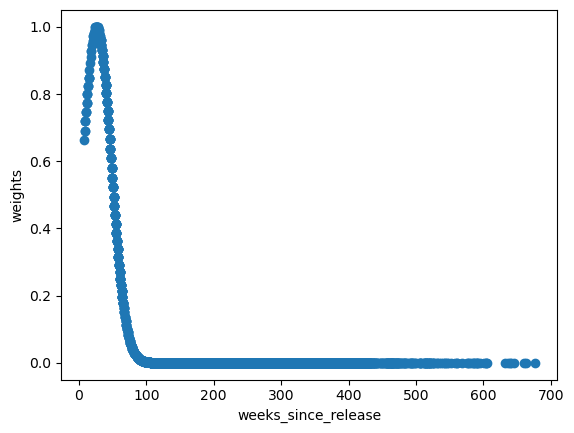

In [393]:
# calculate the weight for each row
train['weights'] = train['weeks_since_release'].apply(lambda x: get_weight(x, std_dev=21))
# draw a plot to show the distribution of the week_since_release and weights
plt.scatter(train['weeks_since_release'], train['weights'])
plt.xlabel('weeks_since_release')
plt.ylabel('weights')
plt.show()

## modeling
loss='absolute_error', subsample=0.5, max_depth = 5, n_estimators = 125, learning_rate=0.081, random_state=42

model_weights: std_dev=7

test WMAPE: 38.88%
train WMAPE: 20.45%
rmse: 321.566
iphone 14 WMAPE: 67.85%


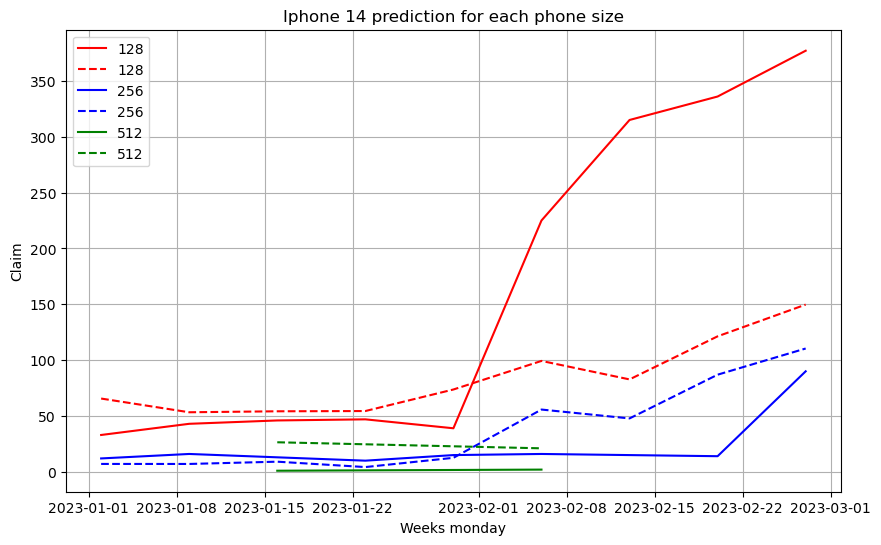

In [397]:
## the model minimizes the overall wmape
## the model minimizes the wmape for iphone 14
model = GradientBoostingRegressor(loss='absolute_error', subsample=0.4, max_depth = 5, 
n_estimators = 135, learning_rate=0.076, random_state=42)

# Fit the model to the training data with custom sample weights
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_fit = model.predict(x_train)

print_metrics(y_test, y_pred, y_train, y_train_fit, show_train=True)

# just test on iphone 14
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
y_14pre = model.predict(x_test14)
print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))

## plot the iphone 14 prediction
# serise to dataframe
y_14pre = pd.DataFrame(y_14pre, columns=['pred'])
y_14pre['weeks_monday'] = x_test14.index
y_14pre = y_14pre.set_index('weeks_monday')
plot_df = pd.concat([x_test14, y_test14, y_14pre], axis=1)

plot_ip14_claim_pred(plot_df, title = 'Iphone 14 prediction for each phone size', target='claim')

## below are the code for tuning different parameters

### tuning on weights standard deviation

best std_dev: 41


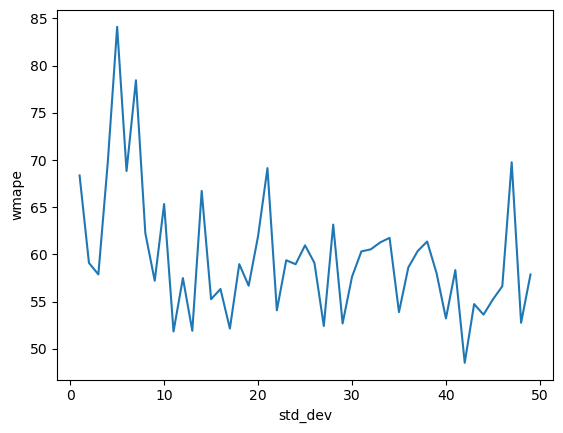

In [308]:
# tune the std_dev of the weights
x_test14 = x_test.loc[x_test['generation_14'] == 1]
y_test14 = test.loc[test['generation_14'] == 1, 'claim']
wps = []

for sd in range(1, 50):
    train['weights'] = train['weeks_since_release'].apply(lambda x: get_weight(x, std_dev=sd))
    model = GradientBoostingRegressor(loss='huber', subsample=0.35, max_depth = 9, n_estimators = 245, 
                                  learning_rate=0.096,random_state=42)

    model.fit(x_train, y_train, sample_weight=train['weights'])

    y_14pre = model.predict(x_test14)
    # print("iphone 14 WMAPE: {:.2f}%".format(wmape(y_test14, y_14pre)))
    wps.append(wmape(y_test14, y_14pre))

# find the index of the minimum wmape
min_wmape = min(wps)
min_wmape_index = wps.index(min_wmape)
print('best std_dev:', min_wmape_index)

# plot the wmape for different std_dev
plt.plot(range(1, 50), wps)
plt.xlabel('std_dev')
plt.ylabel('wmape')
plt.show()

### parameter tuning on ip14 wmape

best learning_rate: 0.076
best n_estimators: 135
best max_depth: 5
best subsample: 0.39999999999999997


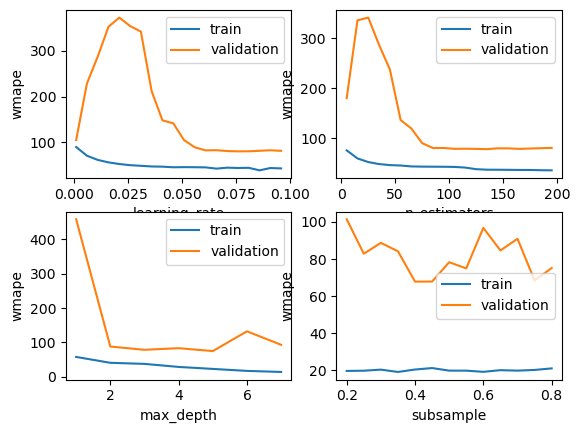

In [388]:
learning_rate = np.arange(.001, 0.1, .005)
n_estimators = np.arange(5, 200, 10)
max_depth = np.arange(1, 8, 1)
subsample = np.arange(.2, .8, .05)
best_lr = min(learning_rate)
best_ne = min(n_estimators)
best_md = min(max_depth)
best_ss = min(subsample)
sample_weight = None
loss = 'absolute_error'
# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2)

train_wmape,  vali_wmape = [], []
for lr in learning_rate:
    model = GradientBoostingRegressor(loss = loss, learning_rate=lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=sample_weight)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_lr = lr

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)
    
print('best learning_rate:', best_lr)
# Plot the train_wmape and vali_wmape against learning_rate
axs[0, 0].plot(learning_rate, train_wmape, label='train')
axs[0, 0].plot(learning_rate, vali_wmape, label='validation')
axs[0, 0].set_xlabel('learning_rate')
axs[0, 0].set_ylabel('wmape')
axs[0, 0].legend()


train_wmape,  vali_wmape = [], []
for n in n_estimators:
    model = GradientBoostingRegressor(loss = loss, n_estimators=n, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=sample_weight)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ne = n

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best n_estimators:', best_ne)
# Plot the train_wmape and vali_wmape against n_estimators
axs[0, 1].plot(n_estimators, train_wmape, label='train')
axs[0, 1].plot(n_estimators, vali_wmape, label='validation')
axs[0, 1].set_xlabel('n_estimators')
axs[0, 1].set_ylabel('wmape')
axs[0, 1].legend()


train_wmape,  vali_wmape = [], []
for md in max_depth:
    model = GradientBoostingRegressor(loss = loss, max_depth=md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=sample_weight)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_md = md

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best max_depth:', best_md)
# Plot the train_wmape and vali_wmape against max_depth
axs[1, 0].plot(max_depth, train_wmape, label='train')
axs[1, 0].plot(max_depth, vali_wmape, label='validation')
axs[1, 0].set_xlabel('max_depth')
axs[1, 0].set_ylabel('wmape')
axs[1, 0].legend()


train_wmape,  vali_wmape = [], []
for ss in subsample:
    model = GradientBoostingRegressor(loss = loss, subsample=ss, max_depth = best_md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=sample_weight)
    
    curr_vali_wmape = wmape(y_test14, model.predict(x_test14))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ss = ss

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)

print('best subsample:', best_ss)
# Plot the train_wmape and vali_wmape against subsample
axs[1, 1].plot(subsample, train_wmape, label='train')
axs[1, 1].plot(subsample, vali_wmape, label='validation')
axs[1, 1].set_xlabel('subsample')
axs[1, 1].set_ylabel('wmape')
axs[1, 1].legend()

# Display the plot
plt.show()

### parameter tuning on wmape

best learning_rate: 0.096
best n_estimators: 245
best max_depth: 6
best subsample: 0.7


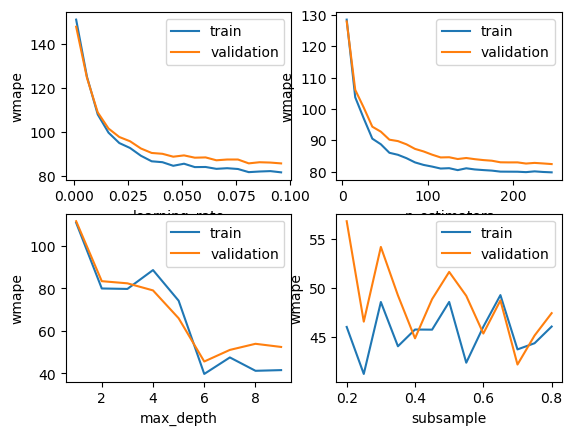

In [343]:
learning_rate = np.arange(.001, 0.1, .005)
n_estimators = np.arange(5, 250, 10)
max_depth = np.arange(1, 10, 1)
subsample = np.arange(.2, .8, .05)
best_lr = min(learning_rate)
best_ne = min(n_estimators)
best_md = min(max_depth)
best_ss = min(subsample)
gener_weights = train['weights']

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2)

train_wmape,  vali_wmape = [], []
for lr in learning_rate:
    model = GradientBoostingRegressor(loss = "huber", learning_rate=lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)

    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_lr = lr

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(curr_vali_wmape)
    
print('best learning_rate:', best_lr)
# Plot the train_wmape and vali_wmape against learning_rate
axs[0, 0].plot(learning_rate, train_wmape, label='train')
axs[0, 0].plot(learning_rate, vali_wmape, label='validation')
axs[0, 0].set_xlabel('learning_rate')
axs[0, 0].set_ylabel('wmape')
axs[0, 0].legend()


train_wmape,  vali_wmape = [], []
for n in n_estimators:
    model = GradientBoostingRegressor(loss = "huber", n_estimators=n, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ne = n

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best n_estimators:', best_ne)
# Plot the train_wmape and vali_wmape against n_estimators
axs[0, 1].plot(n_estimators, train_wmape, label='train')
axs[0, 1].plot(n_estimators, vali_wmape, label='validation')
axs[0, 1].set_xlabel('n_estimators')
axs[0, 1].set_ylabel('wmape')
axs[0, 1].legend()


train_wmape,  vali_wmape = [], []
for md in max_depth:
    model = GradientBoostingRegressor(loss = "huber", max_depth=md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_md = md

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best max_depth:', best_md)
# Plot the train_wmape and vali_wmape against max_depth
axs[1, 0].plot(max_depth, train_wmape, label='train')
axs[1, 0].plot(max_depth, vali_wmape, label='validation')
axs[1, 0].set_xlabel('max_depth')
axs[1, 0].set_ylabel('wmape')
axs[1, 0].legend()


train_wmape,  vali_wmape = [], []
for ss in subsample:
    model = GradientBoostingRegressor(loss = "huber", subsample=ss, max_depth = best_md, n_estimators = best_ne, learning_rate=best_lr, random_state=42)
    model.fit(x_train, y_train, sample_weight=gener_weights)
    
    curr_vali_wmape = wmape(y_test, model.predict(x_test))
    if len(vali_wmape)>0 and curr_vali_wmape < min(vali_wmape):
        best_ss = ss

    train_wmape.append(wmape(y_train, model.predict(x_train)))
    vali_wmape.append(wmape(y_test, model.predict(x_test)))

print('best subsample:', best_ss)
# Plot the train_wmape and vali_wmape against subsample
axs[1, 1].plot(subsample, train_wmape, label='train')
axs[1, 1].plot(subsample, vali_wmape, label='validation')
axs[1, 1].set_xlabel('subsample')
axs[1, 1].set_ylabel('wmape')
axs[1, 1].legend()

# Display the plot
plt.show()